<a href="https://colab.research.google.com/github/AhmedSAad8/Calling-Api-/blob/main/effitientnetaface_ge_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

import warnings
warnings.filterwarnings("ignore")

In [ ]:
root_dir = "/kaggle/input/utkface-new/UTKFace/"

In [ ]:
path_arr = []
age_arr = []
gender_arr = []

for file in tqdm(os.listdir(root_dir)):
    labels = file.split("_")

    filepath = os.path.join(root_dir, file)
    age = int(labels[0])
    gender = int(labels[1])

    path_arr.append(filepath)
    age_arr.append(age)
    gender_arr.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 474814.78it/s]


In [ ]:
df = pd.DataFrame({
    "image_path": path_arr,
    "age": age_arr,
    "gender": gender_arr
})
df.head()

,image_path,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


In [ ]:
df_train, df_valid, df_test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print("Total Size:", df.shape[0])
print("Train Size:", df_train.shape[0])
print("Valid Size:", df_valid.shape[0])
print("Test Size:", df_test.shape[0])

Total Size: 23708
Train Size: 14224
Valid Size: 4742
Test Size: 4742


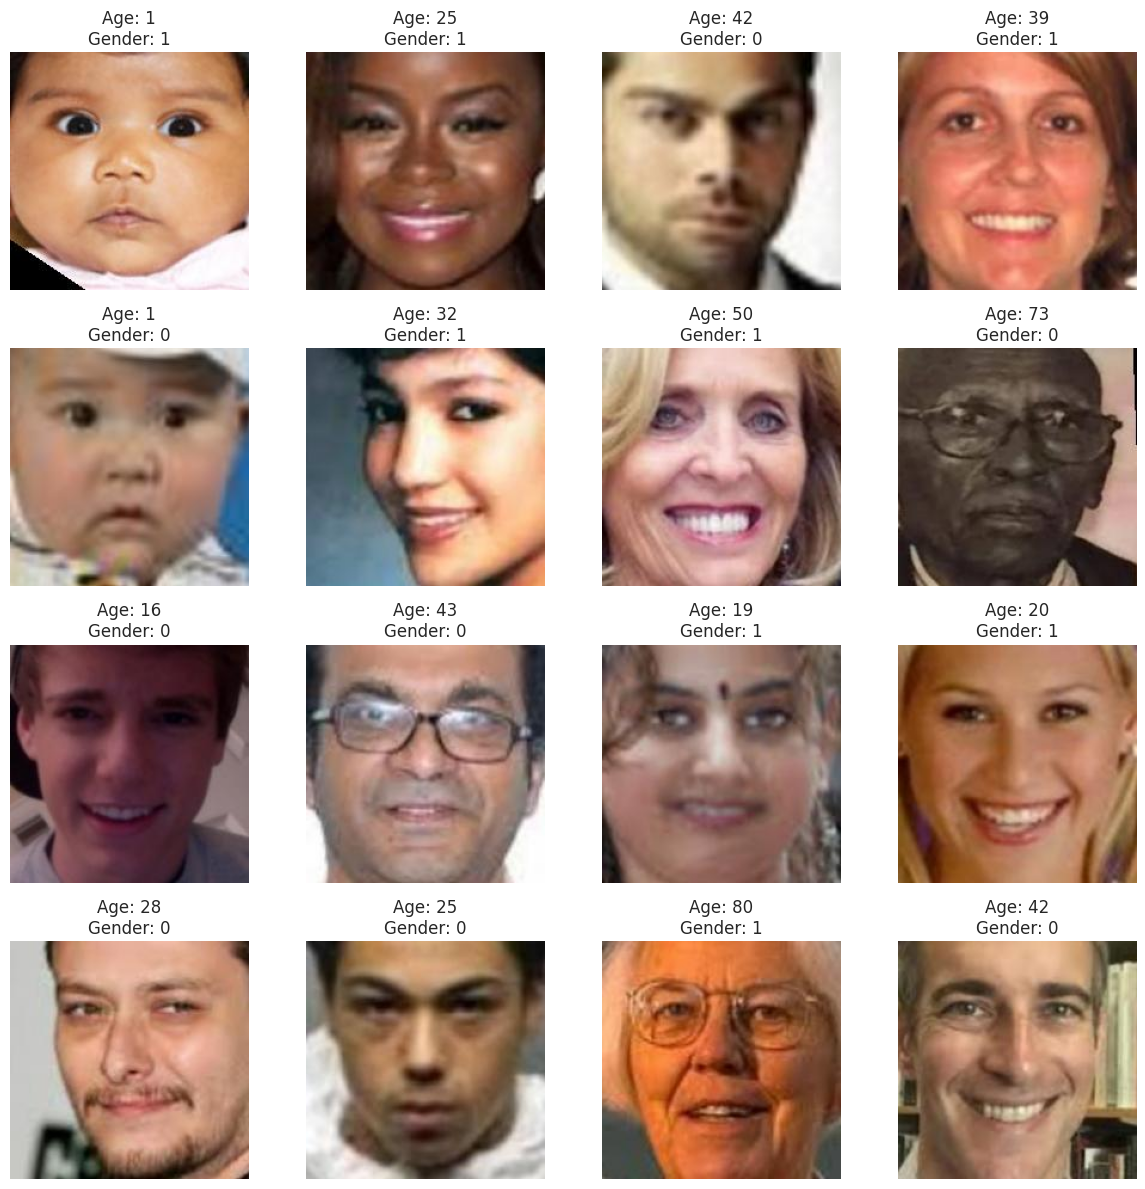

In [ ]:

# Data Visualization
def visualize_df(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image_path']].values[0]
            img_age = df.loc[a][['age']].values[0]
            img_gender = df.loc[a][['gender']].values[0]

            image = Image.open(img_path).convert('RGB')

            ax.imshow(image)
            ax.set_title(f"Age: {img_age}\nGender: {img_gender}")
            ax.axis('off')

        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_df(df_train)

In [ ]:
# Preprocessing
train_img_arr = []
train_gender_arr = []
train_age_arr = []

for idx, row in tqdm(df_train.iterrows()):
    img = load_img(row['image_path'], target_size=(128, 128))
    img = np.array(img, dtype=float)
    img = preprocess_input(img)
    train_img_arr.append(img)
    train_gender_arr.append(row['gender'])
    train_age_arr.append(row['age'])

train_img_arr = np.array(train_img_arr)
train_gender_arr = np.array(train_gender_arr)
train_age_arr = np.array(train_age_arr)


14224it [00:30, 467.92it/s]


In [ ]:
valid_img_arr = []
valid_gender_arr = []
valid_age_arr = []

for idx, row in tqdm(df_valid.iterrows()):
    img = load_img(row['image_path'], target_size=(128, 128))
    img = np.array(img, dtype=float)
    img = preprocess_input(img)
    valid_img_arr.append(img)
    valid_gender_arr.append(row['gender'])
    valid_age_arr.append(row['age'])

valid_img_arr = np.array(valid_img_arr)
valid_gender_arr = np.array(valid_gender_arr)
valid_age_arr = np.array(valid_age_arr)

4742it [00:09, 476.20it/s]


In [ ]:
test_img_arr = []
test_gender_arr = []
test_age_arr = []

for idx, row in tqdm(df_test.iterrows()):
    img = load_img(row['image_path'], target_size=(128, 128))
    img = np.array(img, dtype=float)
    img = preprocess_input(img)
    test_img_arr.append(img)
    test_gender_arr.append(row['gender'])
    test_age_arr.append(row['age'])

test_img_arr = np.array(test_img_arr)
test_gender_arr = np.array(test_gender_arr)
test_age_arr = np.array(test_age_arr)

4742it [00:09, 506.09it/s]


In [ ]:

# Model with EfficientNet
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(128, 128, 3), pooling="avg")
base_model.trainable = False

inputs = Input(shape=(128, 128, 3))
base_output = base_model(inputs)

# Gender branch
gender_dense = Dense(256, activation='relu')(base_output)
gender_drop = Dropout(0.4)(gender_dense)
gender_output = Dense(1, activation='sigmoid', name="gender")(gender_drop)

# Age branch
age_dense = Dense(256, activation='relu')(base_output)
age_drop = Dropout(0.4)(age_dense)
age_output = Dense(1, activation='relu', name="age")(age_drop)

model = Model(inputs=[inputs], outputs=[gender_output, age_output])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam',
              metrics={'gender': 'accuracy', 'age': 'mae'})

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 1280)           │      4,049,571 │ input_layer_3[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        327,936 │ efficientnetb0[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        327,936 │ efficientnetb0[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender (Dense)            │ (None, 1)              │            257 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age (Dense)               │ (None, 1)              │            257 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,705,957 (17.95 MB)

 Trainable params: 656,386 (2.50 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:

# Model Training
history = model.fit(
    x=train_img_arr,
    y=[train_gender_arr, train_age_arr],
    batch_size=32,
    epochs=40,
    validation_data=(valid_img_arr, [valid_gender_arr, valid_age_arr])
)


Epoch 1/40
445/445 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - age_mae: 13.2680 - gender_accuracy: 0.7976 - loss: 13.6869 - val_age_mae: 9.1202 - val_gender_accuracy: 0.8570 - val_loss: 9.4368
Epoch 2/40
445/445 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - age_mae: 9.1605 - gender_accuracy: 0.8369 - loss: 9.5020 - val_age_mae: 8.7081 - val_gender_accuracy: 0.8726 - val_loss: 9.0107
Epoch 3/40
445/445 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - age_mae: 8.6187 - gender_accuracy: 0.8580 - loss: 8.9395 - val_age_mae: 8.6349 - val_gender_accuracy: 0.8730 - val_loss: 8.9255
Epoch 4/40
445/445 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - age_mae: 8.3986 - gender_accuracy: 0.8644 - loss: 8.6980 - val_age_mae: 8.0267 - val_gender_accuracy: 0.8737 - val_loss: 8.3176
Epoch 5/40
445/445 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - age_mae: 8.1438 - gender_accuracy: 0.8719 - loss: 8.4388 - val_age_mae: 7.9400 - val_gender_accuracy: 0.8813 - val_loss: 8.2199
Epoch 6/40
445/445 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - age_mae: 8.0776 - gender_ac

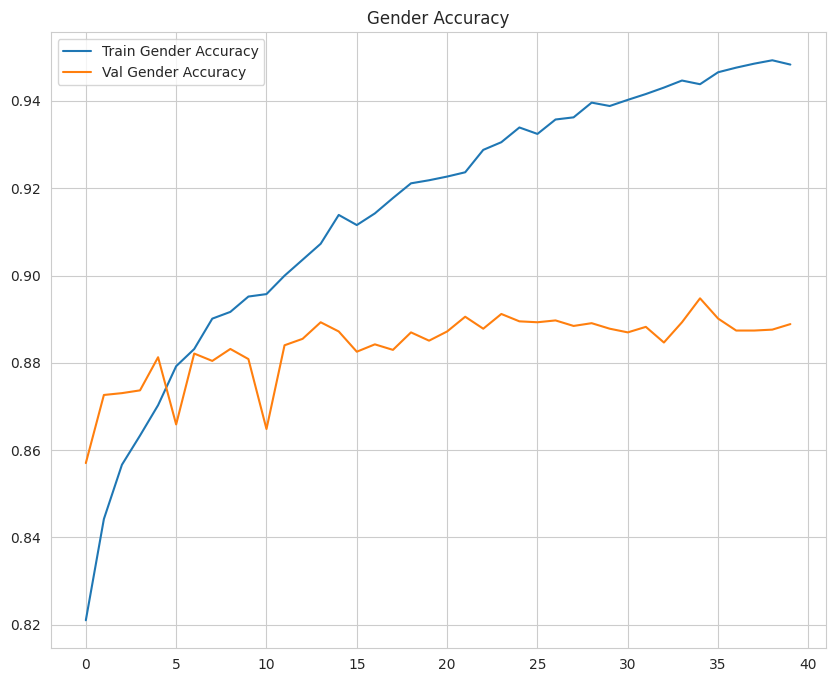

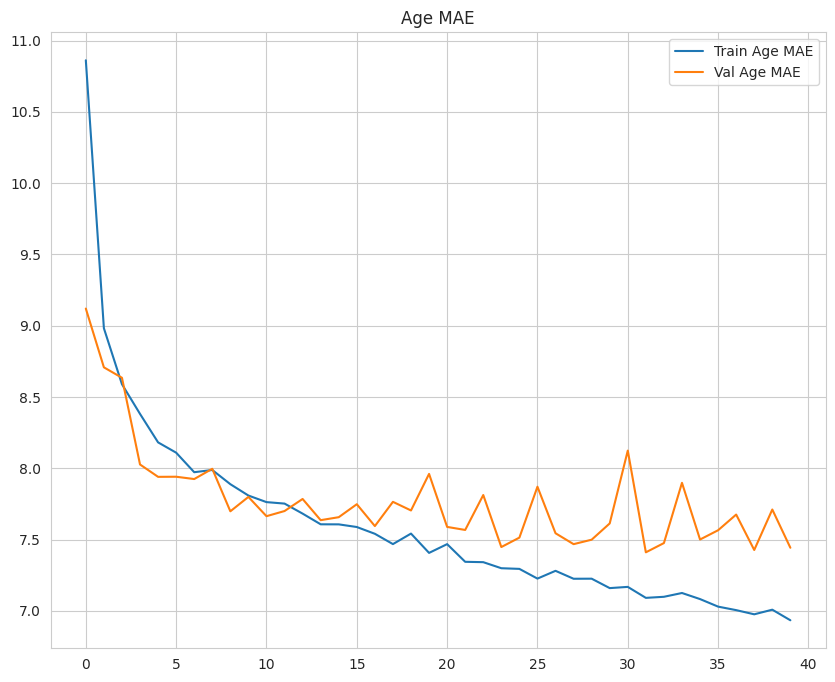

In [ ]:
# Plotting Results
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(10, 8))
plt.title("Gender Accuracy")
plt.plot(history_df["gender_accuracy"], label="Train Gender Accuracy")
plt.plot(history_df["val_gender_accuracy"], label="Val Gender Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
plt.title("Age MAE")
plt.plot(history_df["age_mae"], label="Train Age MAE")
plt.plot(history_df["val_age_mae"], label="Val Age MAE")
plt.legend()
plt.show()

In [ ]:
# Model Evaluation
preds = model.predict(test_img_arr, verbose=0)
pred_gender = (preds[0] > 0.5).astype(int).flatten()
pred_age = np.round(preds[1].flatten())

df_test["pred_age"] = pred_age
df_test["pred_gender"] = pred_gender

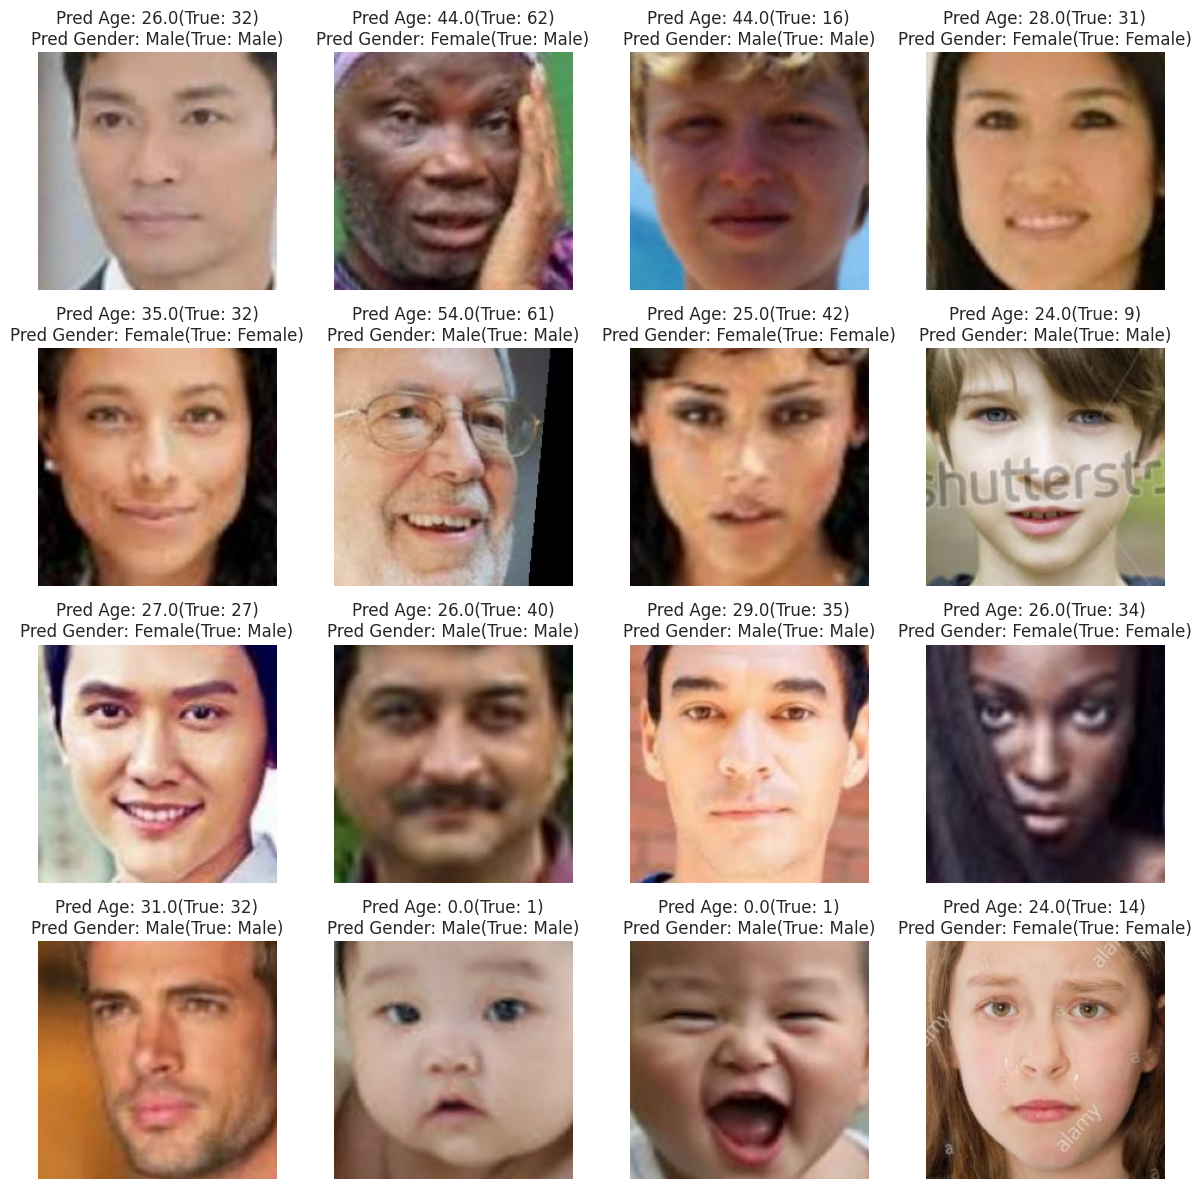

In [ ]:
# Visualization of Results
def visualize_results(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            gender_dict = {0: 'Male', 1: 'Female'}
            img_path = df.loc[a][['image_path']].values[0]
            img_age = df.loc[a][['age']].values[0]
            img_gender = df.loc[a][['gender']].values[0]
            img_pred_age = df.loc[a][['pred_age']].values[0]
            img_pred_gender = df.loc[a][['pred_gender']].values[0]

            image = Image.open(img_path).convert('RGB')

            ax.imshow(image)
            ax.set_title(f"Pred Age: {img_pred_age}(True: {img_age})\nPred Gender: {gender_dict[img_pred_gender]}(True: {gender_dict[img_gender]})")
            ax.axis('off')

        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_results(df_test)

149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


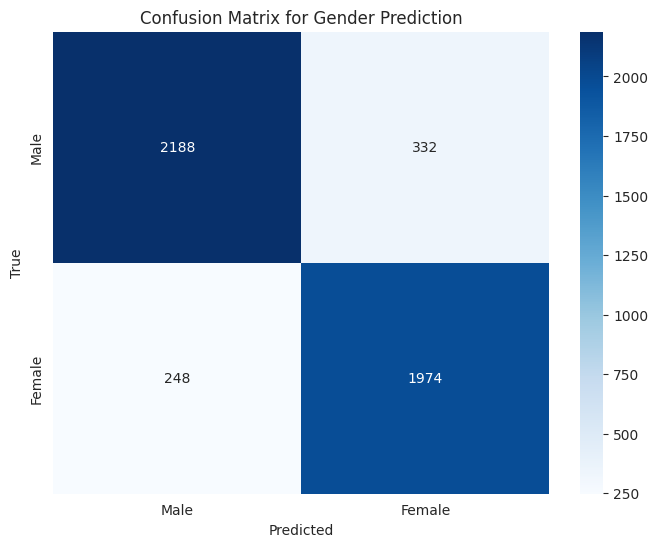

Classification Report for Gender Prediction:
              precision    recall  f1-score   support

        Male       0.90      0.87      0.88      2520
      Female       0.86      0.89      0.87      2222

    accuracy                           0.88      4742
   macro avg       0.88      0.88      0.88      4742
weighted avg       0.88      0.88      0.88      4742



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# predection  code
preds = model.predict(test_img_arr, verbose=1)
pred_gender = (preds[0] > 0.5).astype(int)  # تحويل مخرجات الجنس إلى 0 أو 1
true_gender = test_gender_arr

# Confusion Matrix
cm = confusion_matrix(true_gender, pred_gender)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Gender Prediction')
plt.show()

# Classification Report
report = classification_report(true_gender, pred_gender, target_names=['Male', 'Female'])
print("Classification Report for Gender Prediction:")
print(report)


149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


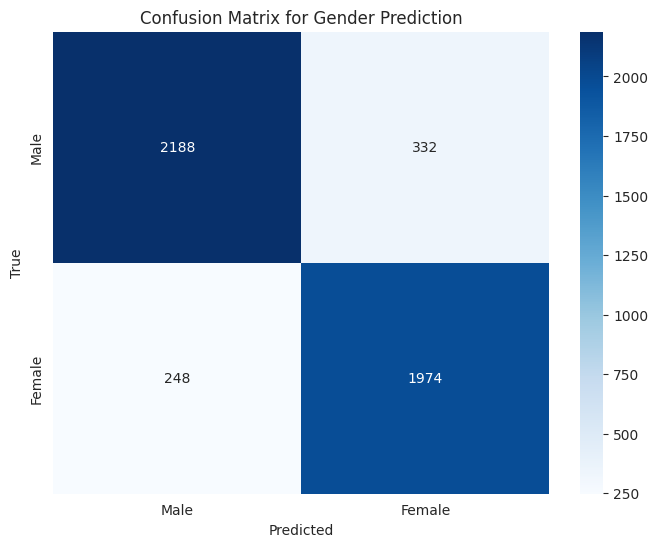

Classification Report for Gender Prediction:
              precision    recall  f1-score   support

        Male       0.90      0.87      0.88      2520
      Female       0.86      0.89      0.87      2222

    accuracy                           0.88      4742
   macro avg       0.88      0.88      0.88      4742
weighted avg       0.88      0.88      0.88      4742



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# model predection
preds = model.predict(test_img_arr, verbose=1)
pred_gender = (preds[0] > 0.5).astype(int)  # تحويل مخرجات الجنس إلى 0 أو 1
true_gender = test_gender_arr

# Confusion Matrix
cm = confusion_matrix(true_gender, pred_gender)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Gender Prediction')
plt.show()

# Classification Report
report = classification_report(true_gender, pred_gender, target_names=['Male', 'Female'])
print("Classification Report for Gender Prediction:")
print(report)
